In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#1. load images

train_folder = "/Users/macbook/Downloads/Projects/Neural Network/seg_train/"
test_folder = "/Users/macbook/Downloads/Projects/Neural Network/seg_test/"

batch_size = 32
img_height = 150
img_width = 150

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_df = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_df = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


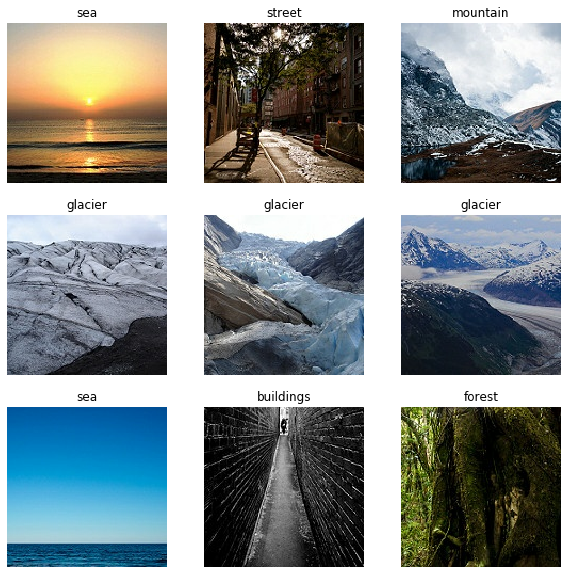

In [3]:
#2. visualise the data

train_class_names = train_df.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_class_names[labels[i]])
        plt.axis("off")
plt.show()

In [4]:
for image_batch, label_batch in train_df:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 150, 150, 3)
(32,)


In [5]:
#3. create the model
#3.1. 1-convolution-layer CNN

# define the model
cnn = Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')
])

# compile the model
cnn.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                5760064   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 5,760,902
Trainable params: 5,760,902
Non-trainable params: 0
______________________________________________

In [6]:
epochs = 20

# fit the model
history = cnn.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs
)

# evaluate the model
cnn.evaluate(train_df)
cnn.evaluate(test_df)

Epoch 1/20
351/351 [==============================] - 114s 325ms/step - loss: 1.6292 - accuracy: 0.4106 - val_loss: 1.4996 - val_accuracy: 0.5381
Epoch 2/20
351/351 [==============================] - 107s 304ms/step - loss: 1.5059 - accuracy: 0.5334 - val_loss: 1.4829 - val_accuracy: 0.5549
Epoch 3/20
351/351 [==============================] - 108s 307ms/step - loss: 1.4433 - accuracy: 0.5943 - val_loss: 1.4294 - val_accuracy: 0.6101
Epoch 4/20
351/351 [==============================] - 115s 327ms/step - loss: 1.3786 - accuracy: 0.6646 - val_loss: 1.4275 - val_accuracy: 0.6119
Epoch 5/20
351/351 [==============================] - 173s 493ms/step - loss: 1.3476 - accuracy: 0.6965 - val_loss: 1.3739 - val_accuracy: 0.6714
Epoch 6/20
351/351 [==============================] - 152s 434ms/step - loss: 1.3133 - accuracy: 0.7305 - val_loss: 1.3728 - val_accuracy: 0.6721
Epoch 7/20
351/351 [==============================] - 120s 343ms/step - loss: 1.2935 - accuracy: 0.7520 - val_loss: 1.3625 -

[1.316476821899414, 0.7233333587646484]

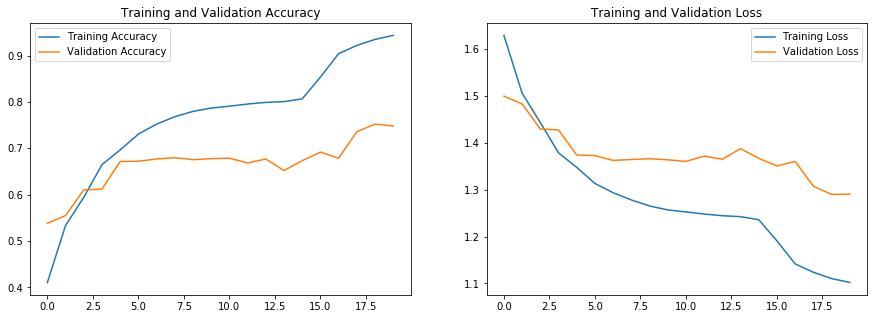

In [10]:
# learning curve
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training and Validation Loss')

plt.show()

In [22]:
#make a prediction

pred_folder = "/Users/macbook/Downloads/Projects/Neural Network/seg_predict/pred_photo.jpeg"

import cv2

img = cv2.imread(pred_folder)
img = cv2.resize(img, (150, 150))

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = cnn.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)

print("This image most likely belongs to {} with a {:.2f} percent confidence"
      .format(train_class_names[np.argmax(score)], 100 * np.max(score)))

tf.Tensor([0.12956257 0.12956253 0.1295626  0.12956253 0.12956253 0.3521872 ], shape=(6,), dtype=float32)
This image most likely belongs to street with a 35.22 percent confidence


In [34]:
print(train_df)

<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int32)>


In [38]:
#4. data augmentation

data_aug = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(
        "horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.08),
    layers.experimental.preprocessing.RandomZoom(0.08),
])


In [39]:
# define the model
cnn1 = Sequential([
    data_aug,
    layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')
])

# compile the model
cnn1.compile(optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

cnn1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                5760064   
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

In [44]:
epochs = 20

# fit the model
history = cnn1.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs
)

# evaluate the model
cnn1.evaluate(train_df)
cnn1.evaluate(test_df)

Epoch 1/20
351/351 [==============================] - 231s 659ms/step - loss: 1.2897 - accuracy: 0.7520 - val_loss: 1.3066 - val_accuracy: 0.7356
Epoch 2/20
351/351 [==============================] - 233s 664ms/step - loss: 1.2906 - accuracy: 0.7515 - val_loss: 1.3116 - val_accuracy: 0.7309
Epoch 3/20
351/351 [==============================] - 217s 617ms/step - loss: 1.2876 - accuracy: 0.7532 - val_loss: 1.2988 - val_accuracy: 0.7452
Epoch 4/20
351/351 [==============================] - 222s 633ms/step - loss: 1.2918 - accuracy: 0.7507 - val_loss: 1.3817 - val_accuracy: 0.6607
Epoch 5/20
351/351 [==============================] - 226s 644ms/step - loss: 1.2886 - accuracy: 0.7535 - val_loss: 1.3230 - val_accuracy: 0.7195
Epoch 6/20
351/351 [==============================] - 223s 635ms/step - loss: 1.2804 - accuracy: 0.7615 - val_loss: 1.3328 - val_accuracy: 0.7099
Epoch 7/20
351/351 [==============================] - 228s 651ms/step - loss: 1.2812 - accuracy: 0.7611 - val_loss: 1.3308 -

[1.3087114095687866, 0.734000027179718]

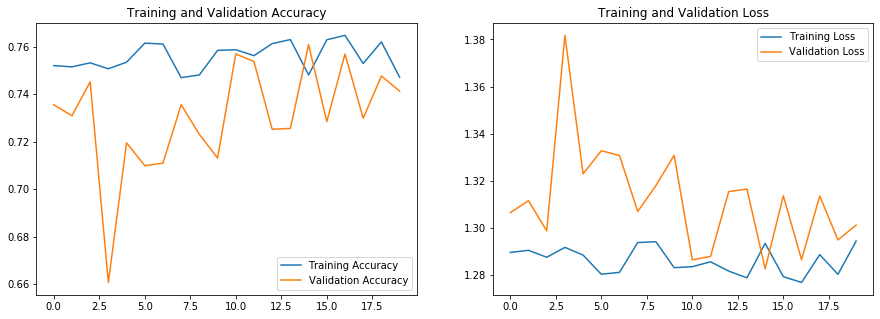

In [45]:
# learning curve
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training and Validation Loss')

plt.show()

In [46]:
# make a prediction

predictions = cnn1.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)

print("This image most likely belongs to {} with a {:.2f} percent confidence"
      .format(train_class_names[np.argmax(score)], 100 * np.max(score)))

tf.Tensor([0.12956251 0.12956251 0.12956251 0.12956251 0.12956251 0.35218742], shape=(6,), dtype=float32)
This image most likely belongs to street with a 35.22 percent confidence
